# Impact Function Calibration

Can we use the NCCS calibration as a general optimisation too?

In [1]:
# Import
import sys
sys.path.append('../..')
import logging
import climada
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import copy
import os
import pycountry
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_log_error
from climada.util import log_level
from climada.entity import ImpactFuncSet, ImpfTropCyclone

from calibration.base import NCCSInput
from calibration.bayesian_optimizer import NCCSBayesianOptimizer, NCCSBayesianOptimizerController
from calibration.rp_errors import rp_rmse
from nccs.utils import folder_naming

logging.getLogger("climada").setLevel("INFO")
warnings.filterwarnings("ignore", category=DeprecationWarning)

LOGGER = logging.getLogger(__name__)

/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


2024-11-13 13:12:44,769 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_DECAY_AT_EXTREME_LATS found in the environment: setting to 1 by default
2024-11-13 13:12:44,771 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_DECAY_BEYOND_ADVISORIES found in the environment: setting to 1 by default
2024-11-13 13:12:44,771 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_KILL_BEYOND_ADVISORIES found in the environment: setting to 1 by default
2024-11-13 13:12:44,772 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_KILL_BEYOND_EXTRATROPICAL found in the environment: setting to 1 by default
2024-11-13 13:12:44,772 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_TARGET_PRESSURE_OVER_SEA found in the environment: setting to 1 by default
2024-11-13 13:12:44,774 - climada.hazard.tc_tracks_synth - INFO - No value for TRACKGEN_TEST_BIAS_TARGET_PRESSURE found in the environment: setting to 0 by default


## User-supplied components of an NCCS calibration

The input to an NCCS calibration looks like this:

```
input = NCCSInput(
    config = config_template,
    data = obs,
    write_impact_functions = write_regional_tc_impact_function,
    return_period_impacts_from_config = return_period_impacts_from_config,
    cost_func = rp_rmse,
    bounds = bounds,
    constraints = constraints,
    linear_param='scale'
)
```

If we're not using the NCCS model at all, then maybe this still works.

Let's go through the individual components and see how this might look.

### 1. Config template

We drop this completely. We'll build an optimisation that doesn't need it. Set the template only to have a run title, required for creating and storing output data.

In [2]:
config_template = {
    'run_title': 'general_usage/test1'
}

## 2. Observation data

This will be the 'flood days' data. It's a vector of ones and zeroes, maybe indexed by date?

For now I'll just set it as a random vector.

In [3]:
obs = pd.DataFrame(dict(
    date = np.arange(1000),
    flood = np.random.binomial(1, 0.1, 1000)
))

# 3. `write_impact_functions`: a method to write custom impact functions from sampled input parameters

We'll scrap this too. It only exists to interact with the NCCS pipeline. But we have to provide something:

In [4]:
def write_impact_functions(**params):
    return None

## 4. `return_period_impacts_from_config`: a method to reproduce the observations with the model

This is the most complex part of the setup.

We'll keep the name the same, but in this experiment, this needs to be a method that takes the input parameters and outputs modelled values of `Y_t`.

The input has to be in this form (called `config` when you define the method)
```
{
    "parameters": {
        "u": 0.0,
        "th1": 0.0,
        "th2": 0.0,
        "l": 0.0
    }
}
```
The method returns a vector of the modelled `Y_t` values (i.e. the values BEFORE the logistic regression is fitted).

For now I'll give a dummy method. The real thing will have the complicated math from the paper.

In [5]:
# this function gives values of Y_t that increase with higher values of each of the input parameters (except for theta2 which we penalise instead)
def calculate_y_t_from_config(config):
    params = config['parameters']
    out = copy.deepcopy(obs)
    scaling = (params['u'] + params['th1'] - params['th2'] + params['l']) / 3
    out['flood'] = out['flood'] * scaling
    return out

In [6]:
from climada.engine import Impact

## 5. The cost function

The cost function is the Pseudo-R2 calculated from the logistic regression. It'll be a function you provide that takes the vector of `Y_t` values and the observations, fits the regression model and returns the value of the fit.

You'll also need to multiply it by -1 since the optimisation tries to minimise whatever cost function it gets, and you want to maximise the R2.

In [ ]:
from sklearn.metrics import root_mean_squared_error

# Just using RMSE as a placeholder
def cost_function(y_t, obs):
    return root_mean_squared_error(obs, y_t)   

## 6. The input parameter bounds

Here  we specify the parameter space to search

In [8]:
bounds = {"u": (0, 1), "th1": (0, 1), "th2": (0, 1), "l": (0, 1)}

# Constraints

The BayesianOptimization also takes `constraints`. Here we need theta 1 and theta 2 to sum to less than one.

In [9]:
from scipy.optimize import NonlinearConstraint

def constraint_function(u, th1, th2, l):
    return th1 + th2

constraints = NonlinearConstraint(constraint_function, 0, 1)

# Linear parameter

We don't use this

# Run the calibration

Now we can put this all together!

In [10]:
from climada.util import log_level

logging.getLogger('calibration').setLevel(logging.DEBUG)


# Define calibration input
with log_level("WARNING", name_prefix="climada"):
    with log_level("INFO", name_prefix="climada.util.calibrate"):
        input = NCCSInput(
            config = config_template,
            data = obs,
            write_impact_functions = write_impact_functions,
            return_period_impacts_from_config = calculate_y_t_from_config,
            cost_func = cost_function,
            bounds = bounds,
            constraints = None,
        )

        # Create and run the optimizer
        opt = NCCSBayesianOptimizer(input)
        controller = NCCSBayesianOptimizerController.from_input(input)
        bayes_output = opt.run(controller)
        bayes_output.params  # The optimal parameters

2024-11-13 13:12:45,345 - calibration.base - DEBUG - Creating the NCCSInput object
2024-11-13 13:12:45,347 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimizer
2024-11-13 13:12:45,347 - calibration.base - DEBUG - Initialising an NCCSOptimizer without a cache
2024-11-13 13:12:45,348 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimization
2024-11-13 13:12:45,350 - calibration.bayesian_optimizer - DEBUG - Starting the execution of the NCCSBayesianOptimizer
2024-11-13 13:12:45,351 - calibration.bayesian_optimizer - INFO - Gathering any data saved from previous runs in /Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/results/general_usage
2024-11-13 13:12:45,351 - calibration.bayesian_optimizer - DEBUG - Found a total of 0 existing outputs (full or partial)
2024-11-13 13:12:45,352 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2024-11-13 13:12:45,363 - calibration.bayesian_optimizer - DEBUG -

/Users/chrisfairless/Projects/climada/climada_python/climada/util/calibrate/bayesian_optimizer.py:439: RuntimeWarning: divide by zero encountered in scalar divide
  impr = (self._improvements[-1].target / target) - 1


2024-11-13 13:12:54,651 - calibration.bayesian_optimizer - DEBUG - Probing params: {'l': 1.0, 'th1': 1.0, 'th2': 0.0, 'u': 1.0}
2024-11-13 13:12:54,652 - calibration.base - DEBUG - Reading previous model output for this parameter combination: /Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/results/general_usage/test10cc5d861/direct/reproduced_obs.csv
2024-11-13 13:12:54,658 - calibration.base - DEBUG - Cost function: -0.0
Data point [1. 1. 0. 1.] is not unique. 1 duplicates registered. Continuing ...
2024-11-13 13:12:55,543 - calibration.bayesian_optimizer - DEBUG - Probing params: {'l': 1.0, 'th1': 1.0, 'th2': 0.0, 'u': 1.0}
2024-11-13 13:12:55,544 - calibration.base - DEBUG - Reading previous model output for this parameter combination: /Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/results/general_usage/test10cc5d861/direct/reproduced_obs.csv
2024-11-13 13:12:55,551 - calibration.base - DEBUG - Cost function: -0.0
Data point [1. 1. 0. 1.] is not unique. 2 dupl

In [11]:
bayes_output

NCCSBayesianOptimizerOutput(params={'l': 1.0, 'th1': 1.0, 'th2': 0.0, 'u': 1.0}, target=-0.0, p_space=<bayes_opt.target_space.TargetSpace object at 0x15bdc7110>)

In [12]:
output_dir = Path(folder_naming.get_direct_output_dir(config_template['run_title'])).parent.parent
calibration_output_path = Path(output_dir, 'optimisation_output.hdf5')

In [13]:
# Save output to file
bayes_output.to_hdf5(calibration_output_path)

In [14]:
# Upload the output to S3
# from nccs.utils.s3client import upload_project_folder_to_s3
# upload_project_folder_to_s3(project_folder)

In [15]:
# Read output from file
from calibration.bayesian_optimizer import NCCSBayesianOptimizerOutput
bayes_output = NCCSBayesianOptimizerOutput.from_hdf5(calibration_output_path)

Data point [1. 1. 0. 1.] is not unique. 1 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 2 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 3 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 4 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 5 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 6 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 7 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 8 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 9 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 10 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 11 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not unique. 12 duplicates registered. Continuing ...
Data point [1. 1. 0. 1.] is not uniqu

## Evaluate Output

The Bayesian Optimizer returns the entire parameter space it sampled and we can investigate the cost function's behaviour within this space.

Here we print the samples examined by the optimizer. Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [16]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

Parameters                                 Calibration
                   l       th1       th2         u Cost Function
Iteration                                                       
0           0.417022  0.720324  0.000114  0.302333      0.081830
1           0.146756  0.092339  0.186260  0.345561      0.136429
2           0.396767  0.538817  0.419195  0.685220      0.094308
3           0.204452  0.878117  0.027388  0.670468      0.066827
4           0.417305  0.558690  0.140387  0.198101      0.103113
...              ...       ...       ...       ...           ...
1019        1.000000  1.000000  0.000000  1.000000      0.000000
1020        1.000000  1.000000  0.000000  1.000000      0.000000
1021        1.000000  1.000000  0.000000  1.000000      0.000000
1022        1.000000  1.000000  0.000000  1.000000      0.000000
1023        1.000000  1.000000  0.000000  1.000000      0.000000

[1024 rows x 5 columns]

In contrast, the controller only tracks the consecutive improvements of the best guess:

In [17]:
controller.improvements()

,iteration,random,target,improvement
sample,,,,
0,0,True,-0.081830,inf
3,0,True,-0.066827,0.224495
5,0,True,-0.044684,0.495549
9,0,True,-0.039174,0.140663
26,0,True,-0.029078,0.347218
62,0,True,-0.022338,0.301702
256,0,False,-0.000000,inf


Notice that the optimal parameter set is not necessarily the last entry in the parameter space!
Therefore, let's order the parameter space by the ascending cost function values.

In [18]:
p_space_df = p_space_df.sort_values(("Calibration", "Cost Function"), ascending=True)
p_space_df

Parameters                                 Calibration
                   l       th1       th2         u Cost Function
Iteration                                                       
1015        1.000000  1.000000  0.000000  1.000000      0.000000
1014        1.000000  1.000000  0.000000  1.000000      0.000000
1013        1.000000  1.000000  0.000000  1.000000      0.000000
1012        1.000000  1.000000  0.000000  1.000000      0.000000
1011        1.000000  1.000000  0.000000  1.000000      0.000000
...              ...       ...       ...       ...           ...
74          0.377924  0.079626  0.982817  0.181613      0.175343
245         0.142793  0.094100  0.870192  0.236869      0.178110
587         0.263139  0.071610  0.978673  0.236384      0.178693
535         0.036068  0.200182  0.788301  0.012097      0.185637
720         0.037584  0.147503  0.922639  0.044155      0.193683

[1024 rows x 5 columns]

We can then plot the cost function within the parameter space:

[<Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, l)', ylabel='(Parameters, th1)'>,
 <Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, l)', ylabel='(Parameters, th2)'>,
 <Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, l)', ylabel='(Parameters, u)'>,
 <Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, th1)', ylabel='(Parameters, th2)'>,
 <Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, th1)', ylabel='(Parameters, u)'>,
 <Axes: title={'center': 'Cost function within parameter space'}, xlabel='(Parameters, th2)', ylabel='(Parameters, u)'>]

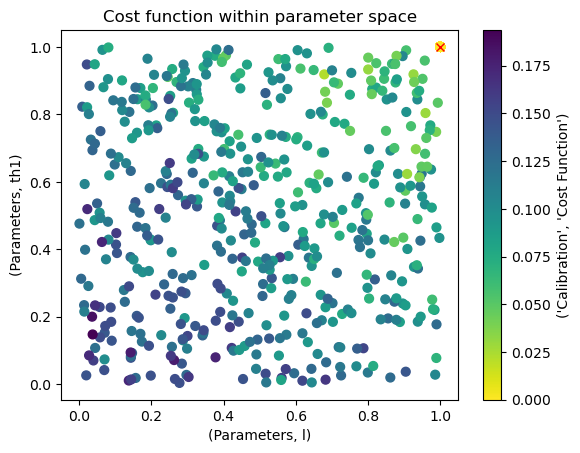

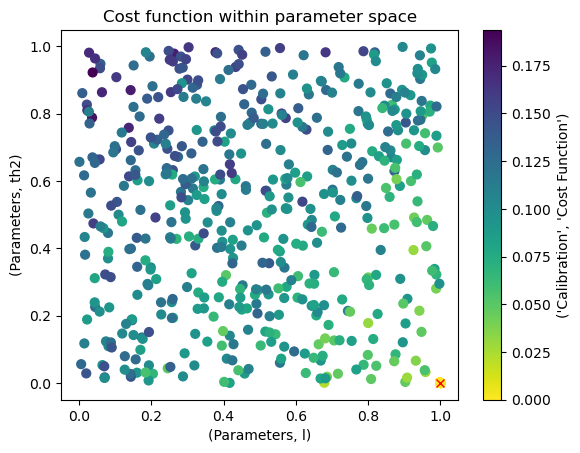

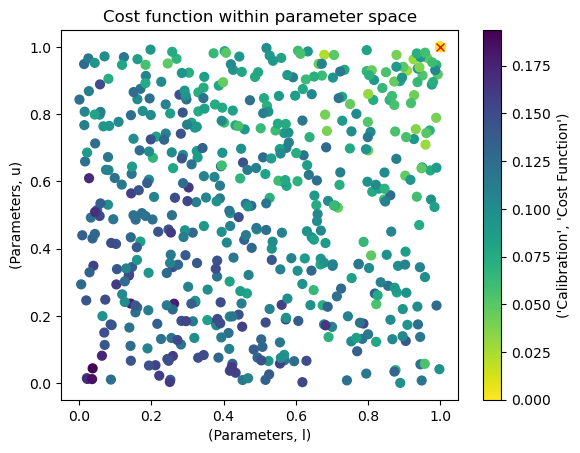

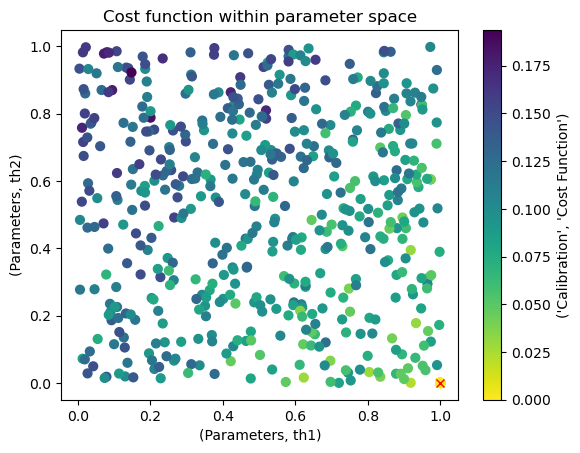

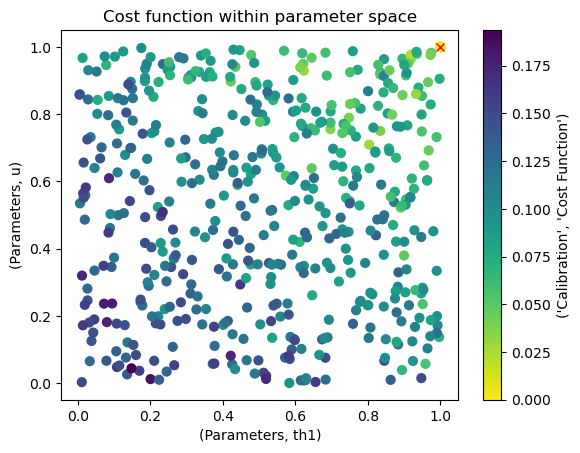

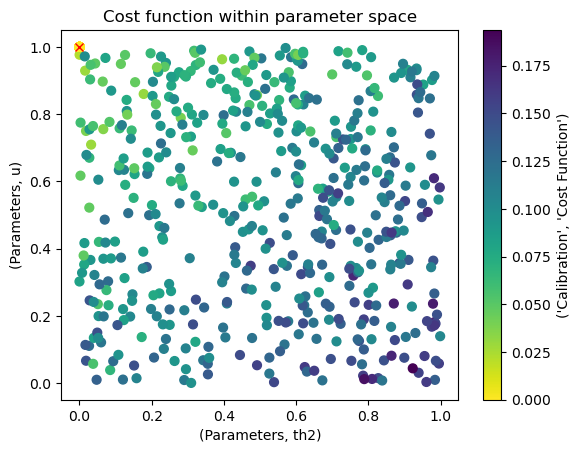

In [19]:
import matplotlib as mpl
bayes_output.plot_p_space(title = 'Cost function within parameter space')
# bayes_output.plot_p_space(norm = mpl.colors.LogNorm(), title = 'Cost function within parameter space (log colour scale)')

And print the 'optimal' parameters

In [20]:
# optimal_params = p_space_df["Parameters"].iloc[0, :].to_dict()
optimal_params = bayes_output.get_optimal_params()
optimal_params

{'l': 1.0, 'th1': 1.0, 'th2': 0.0, 'u': 1.0}